In [2]:
!pip install pydicom

     |████████████████████████████████| 1.9 MB 5.8 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
!pip install seaborn

     |████████████████████████████████| 285 kB 5.8 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [4]:
import numpy as np
import h5py
import os
import pydicom
import pandas as pd
import math
import seaborn as sns
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from itertools import compress
from scipy import ndimage
from functions.data_import import *
from functions.plot_sequence import *
from functions.config import *

## Config variables

stored in functions/config.py

# Create image info file
only needs to be done once

In [5]:
# create_file_list(PATH_DICOM, PATH_IMAGE_INFO)

## Functions

are saved in seperate files

## Import Baseline Dataset

In [6]:
baseline_data = pd.read_csv(PATH_BASELINE, sep = " ")
baseline_data.p_id = [format(id, '03d') for id in baseline_data.p_id] 
# baseline_data.p_id

FileNotFoundError: [Errno 2] No such file or directory: '../data/baseline_data_DWI.csv'

## Load all paths to images

In [4]:
data_info = pd.read_csv(PATH_IMAGE_INFO)
data_info.patient = [format(id, '03d') for id in data_info.patient] 
# data_info.patient

## Sequence Types

In [5]:
# set(data_info['sequence'])

In [6]:
# set(data_info['description'])

- Some Patients have the same description for two differnet sequences
- Sequence Types are unique (every sequence has a different name)
- But: Patient 4 lacks all Sequence Types
- Patient 8 has different names for sequence types

## Import DICOM images to h5

only needs to be done once

In [7]:
def get_labels_from_jpg_h5(pid):
    with h5py.File(PATH_JPG_H5, 'r') as dd:
        patients = [p.decode() for p in dd['pat_3c']]
        indices = [i for i, x in enumerate(patients) if x == pid]
        labels = np.array(dd['Y'][indices]).astype(float)
    return labels

def adjust_for_missing(labels, pid):
    cleanup = pd.read_csv(PATH_CLEAN_UP, sep = ';')
    cleanup.pid = [format(id, '03d') for id in cleanup.pid]
    status = cleanup.needs_adjustment[cleanup.pid == pid].values

    ## check if status of patient is ok or nok
    if(status == 0):
        print('patient {}: writing labels as is'.format(pid))

    elif(status == 1): # status is not ok --> print compare jpg and dicom

        reason = cleanup.reason_for_adjustment[cleanup.pid == pid].values

        if(reason == 'dicom image missing'):
            print('patient {}: {}'.format(pid, reason))
            issue = 0
        if(reason == 'jpg image missing'):
            print('patient {}: {}'.format(pid, reason))
            issue = 1
        if(reason == 'inverse'):
            print('patient {}: {}'.format(pid, reason))
            issue = 2

        if(issue == 0): ## if dicom slice is missing: remove label
            p = cleanup.removed[cleanup.pid == pid].item()
            p = str(p)
            rm_label = [int(i) for i in p.split(',')]
            labels = np.delete(labels, rm_label)
        if(issue == 1): ## if jpg slice is missing: insert nan
            p = cleanup.removed[cleanup.pid == pid].item()
            p = str(p)
            rm_slice = [int(i) for i in p.split(',')]
            for i in rm_slice:
                labels = np.insert(labels, i, np.nan)
            labels = pd.Series(labels)
            labels = labels.interpolate()
            labels = np.array(labels)
            labels = labels.flatten()

        if(issue == 2): ## order of images is inversed
            labels = labels[::-1]

    else:
        print('patient {}: will get removed'.format(pid))
        labels = np.array([3] * 30)
        
    return labels

def interpolate(labels):
    scaling_factor = IMAGE_DIMENSIONS_3D[2]/labels.shape[0]
    labels = ndimage.zoom(labels, scaling_factor)
    labels = np.round(labels, 2)
    labels = [np.min([1, l]) if l < 3 else l for l in labels]
    labels = [np.max([0, l]) for l in labels]
    return labels

def convert_labels_from_jpg(pid):
    labels = get_labels_from_jpg_h5(pid)
    labels = adjust_for_missing(labels, pid)
    labels = interpolate(labels)
    labels = np.expand_dims(labels, axis=0)
    return labels
    

In [8]:
def dicom_3d_to_h5py():

    first_patient = True

    if os.path.exists(PATH_3D_H5):
        os.remove(PATH_3D_H5)

    data_info = pd.read_csv(PATH_IMAGE_INFO)
    baseline_data = pd.read_csv(PATH_CLEAN_UP, sep = ";")
    data_info.patient = [format(id, '03d') for id in data_info.patient]
    baseline_data.pid = [format(id, '03d') for id in baseline_data.pid]

    patient_list = list(baseline_data.pid[baseline_data.in_database == 1])
    patient_list.sort()

    with h5py.File(PATH_3D_H5, 'a') as f:
        for patient_number in patient_list:
            
            print('\n loading sequence for patient {}'.format(patient_number))
            if baseline_data.jpg_available.loc[baseline_data.pid == patient_number].values == 0:
                print('patient {} has no baseline values. Sequence will not be loaded.'.format(patient_number))
                continue

            ## copy patient specific filepaths
            patient_data = data_info[data_info.patient == patient_number].copy()

            ## check if patient has a b1000t sequence
            in_set = []
            if patient_data.sequence.isnull().sum() == len(patient_data.sequence): ## all entries are empty
                in_set.append(False)
            else:
                for sequence_type in set(patient_data.sequence):
                    in_set.append('b1000t' in sequence_type)

            ## if patient has no or more than one b1000t sequence: choose sequence by hand
            if sum(in_set) != 1:
                ## --> load images in amide, choose image by name
                print('which image should be loaded?')

                print('0 - none')
                for index, image in enumerate(set(patient_data.description)):
                    print('{} - {}'.format(index+1, image))

                choice = input('>')
                if choice == '0':
                    continue
                chosen_sequence = list(set(patient_data.description))[int(choice) - 1]

                print('{} {} \n'.format(' '.ljust(15), chosen_sequence))
                file_list = list(patient_data.filepath[patient_data.description == chosen_sequence])


            ## patient has one b1000t sequence: choose sequence automatically
            else:
                for sequence_type in set(patient_data.sequence):
                    if 'b1000t' in sequence_type:

                        print('{} {} \n'.format(sequence_type.ljust(15), \
                            set(patient_data.description[patient_data.sequence == sequence_type])))
                        file_list = list(patient_data.filepath[patient_data.sequence == sequence_type])
                    else:
                        continue

            raw_3d_image = load_images_3D(file_list)
            scaled_3d_image = scale_array_3D(raw_3d_image, IMAGE_DIMENSIONS_3D)

            # Image matrices
            X = scaled_3d_image[np.newaxis, :, :, :]
            # Image labels (1=stroke, 0=TIA)
            Y = convert_labels_from_jpg(patient_number)
            Y = np.array(Y)
            # Patient ID's
            pat = np.string_([patient_number])
            # Path to images
            path = np.string_([file_list[0][:22]])
            # Patient labels (1=stroke, 0=TIA)
            stroke = baseline_data.stroke.loc[baseline_data.pid == patient_number].values
            stroke = np.array(stroke)
            
            ## write to h5py sequentially
            ms = [id for id in IMAGE_DIMENSIONS_3D]
            ms.insert(0, None)
            ms = tuple(ms)

            if first_patient: ## initialize dataset
                f.create_dataset('X', data = X, maxshape = ms, chunks = True)
                f.create_dataset('Y', data = Y, maxshape = (None, 30), chunks = True)
                f.create_dataset('stroke', data = stroke, maxshape = (None,), chunks = True)
                f.create_dataset('pat', data = pat, maxshape = (None,), chunks = True)
                f.create_dataset('path', data = path, maxshape = (None,), chunks = True)
                first_patient = False

            else: ## append dataset
                f['X'].resize((f['X'].shape[0] + X.shape[0]), axis = 0)
                f['X'][-X.shape[0]:, :] = X
                f['Y'].resize((f['Y'].shape[0] + Y.shape[0]), axis = 0)
                f['Y'][-Y.shape[0]:, :] = Y
                f['stroke'].resize((f['stroke'].shape[0] + stroke.shape[0]), axis = 0)
                f['stroke'][-stroke.shape[0]:] = stroke
                f['pat'].resize((f['pat'].shape[0] + pat.shape[0]), axis = 0)
                f['pat'][-pat.shape[0]:] = pat
                f['path'].resize((f['path'].shape[0] + path.shape[0]), axis = 0)
                f['path'][-path.shape[0]:] = path

In [9]:
# dicom_3d_to_h5py()

## Checking Dataset

In [7]:
with h5py.File(PATH_3D_H5, 'r') as dd:
    print(list(dd.keys()))
    print(dd['X'].shape)
    print(dd['Y'].shape)

['X', 'Y', 'pat', 'path', 'stroke']
(497, 128, 128, 30)
(497, 30)


## Plots

In [12]:
def plot_3d_slices(data, label, pid, orientation = 'axial', vmax = False):
    data = normalize_array(data)
    pixel_spacing = np.arange(0.0, IMAGE_DIMENSIONS_3D[0], 1), \
                    np.arange(0.0, IMAGE_DIMENSIONS_3D[1], 1), \
                    np.arange(0.0, IMAGE_DIMENSIONS_3D[2], 1),

    n_slices = 30
    n_cols = 8
    n_rows = 4
    aspect_ratio = 1
    base_size = 4
    fig_size = (n_cols*base_size/aspect_ratio, n_rows*base_size)
    fig = plt.figure(figsize=fig_size)

    if orientation == 'axial':
        indeces = np.linspace(start=0, stop=data.shape[2]-1, num=n_slices)
    else:
        indeces = np.linspace(start=0, stop=data.shape[0]-1, num=n_slices)

    sp = 1
    for index in np.nditer(indeces.astype(int)):
        if orientation == 'coronal':
            image = np.rot90(data[index, :, ], k = 3)
            a = pixel_spacing[0]
            b = pixel_spacing[2]
        elif orientation == 'sagital':
            image = np.rot90(data[:, index, :], k = 3)
            a = pixel_spacing[1]
            b = pixel_spacing[2]
        else:
            image = np.rot90(data[:, :, index], k = 2)
            a = pixel_spacing[0]
            b = pixel_spacing[1]
        ax = fig.add_subplot(n_rows, n_cols, sp)
        ax.pcolormesh(a, b, image, cmap="gray", vmin = 0, vmax = vmax)
        # ax.pcolormesh(a, b, image, cmap="gray")
        ax.text(80, 20, label[index], fontsize = 30, color = "w")
        if sp == 1:
            ax.text(10, 100, pid, fontsize = 50, color = "w")
        ax.set_aspect('equal', 'box')
        ax.set_axis_off()
        sp += 1

    fig.tight_layout(pad=0.0)
#     p = '../MRIs/{}_3D_labels.png'.format(pid)
#     fig.savefig(p)

In [9]:
def load_from_h5(patient_nb):
    dd = h5py.File(PATH_3D_H5, 'r')
    patients = [p.decode() for p in dd['pat']]

    mri = np.array(dd['X'])[patients.index(patient_nb)]
    labels = np.array(dd['Y'])[patients.index(patient_nb)]
    return mri, labels

In [10]:
def plot_spectrum(pid):
    mri, labels = load_from_h5(pid)
    image = normalize_array(mri) # normalize for plotting over whole volume

    fig, axes = plt.subplots(30, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize = (8, 50))
    plt.suptitle("Patient {}".format(pid), fontsize = 20)
    for i in range(30):
        values = mri[:, :, i].flatten()
        slice = image[:, :, i]
        sns.distplot(ax = axes[i, 0], a=values, bins = 60)
        ax = fig.add_subplot(30, 2, (i+1)*2)
        ax.imshow(slice, vmin = 0, vmax = 1, cmap='gray')
        ax.set_aspect('equal', 'box')
        ax.set_axis_off()
        axes[i, 0].set(xlim=(-10, 1000))
        axes[i, 0].set(ylim=(0, 0.06))
        axes[i, 1].set_axis_off()
        if i < 29:
            axes[i, 0].get_xaxis().set_visible(False)
    fig.subplots_adjust(top=0.97)
    p = '../MRIs/{}_3D_histograms.png'.format(pid)
    fig.savefig(p)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


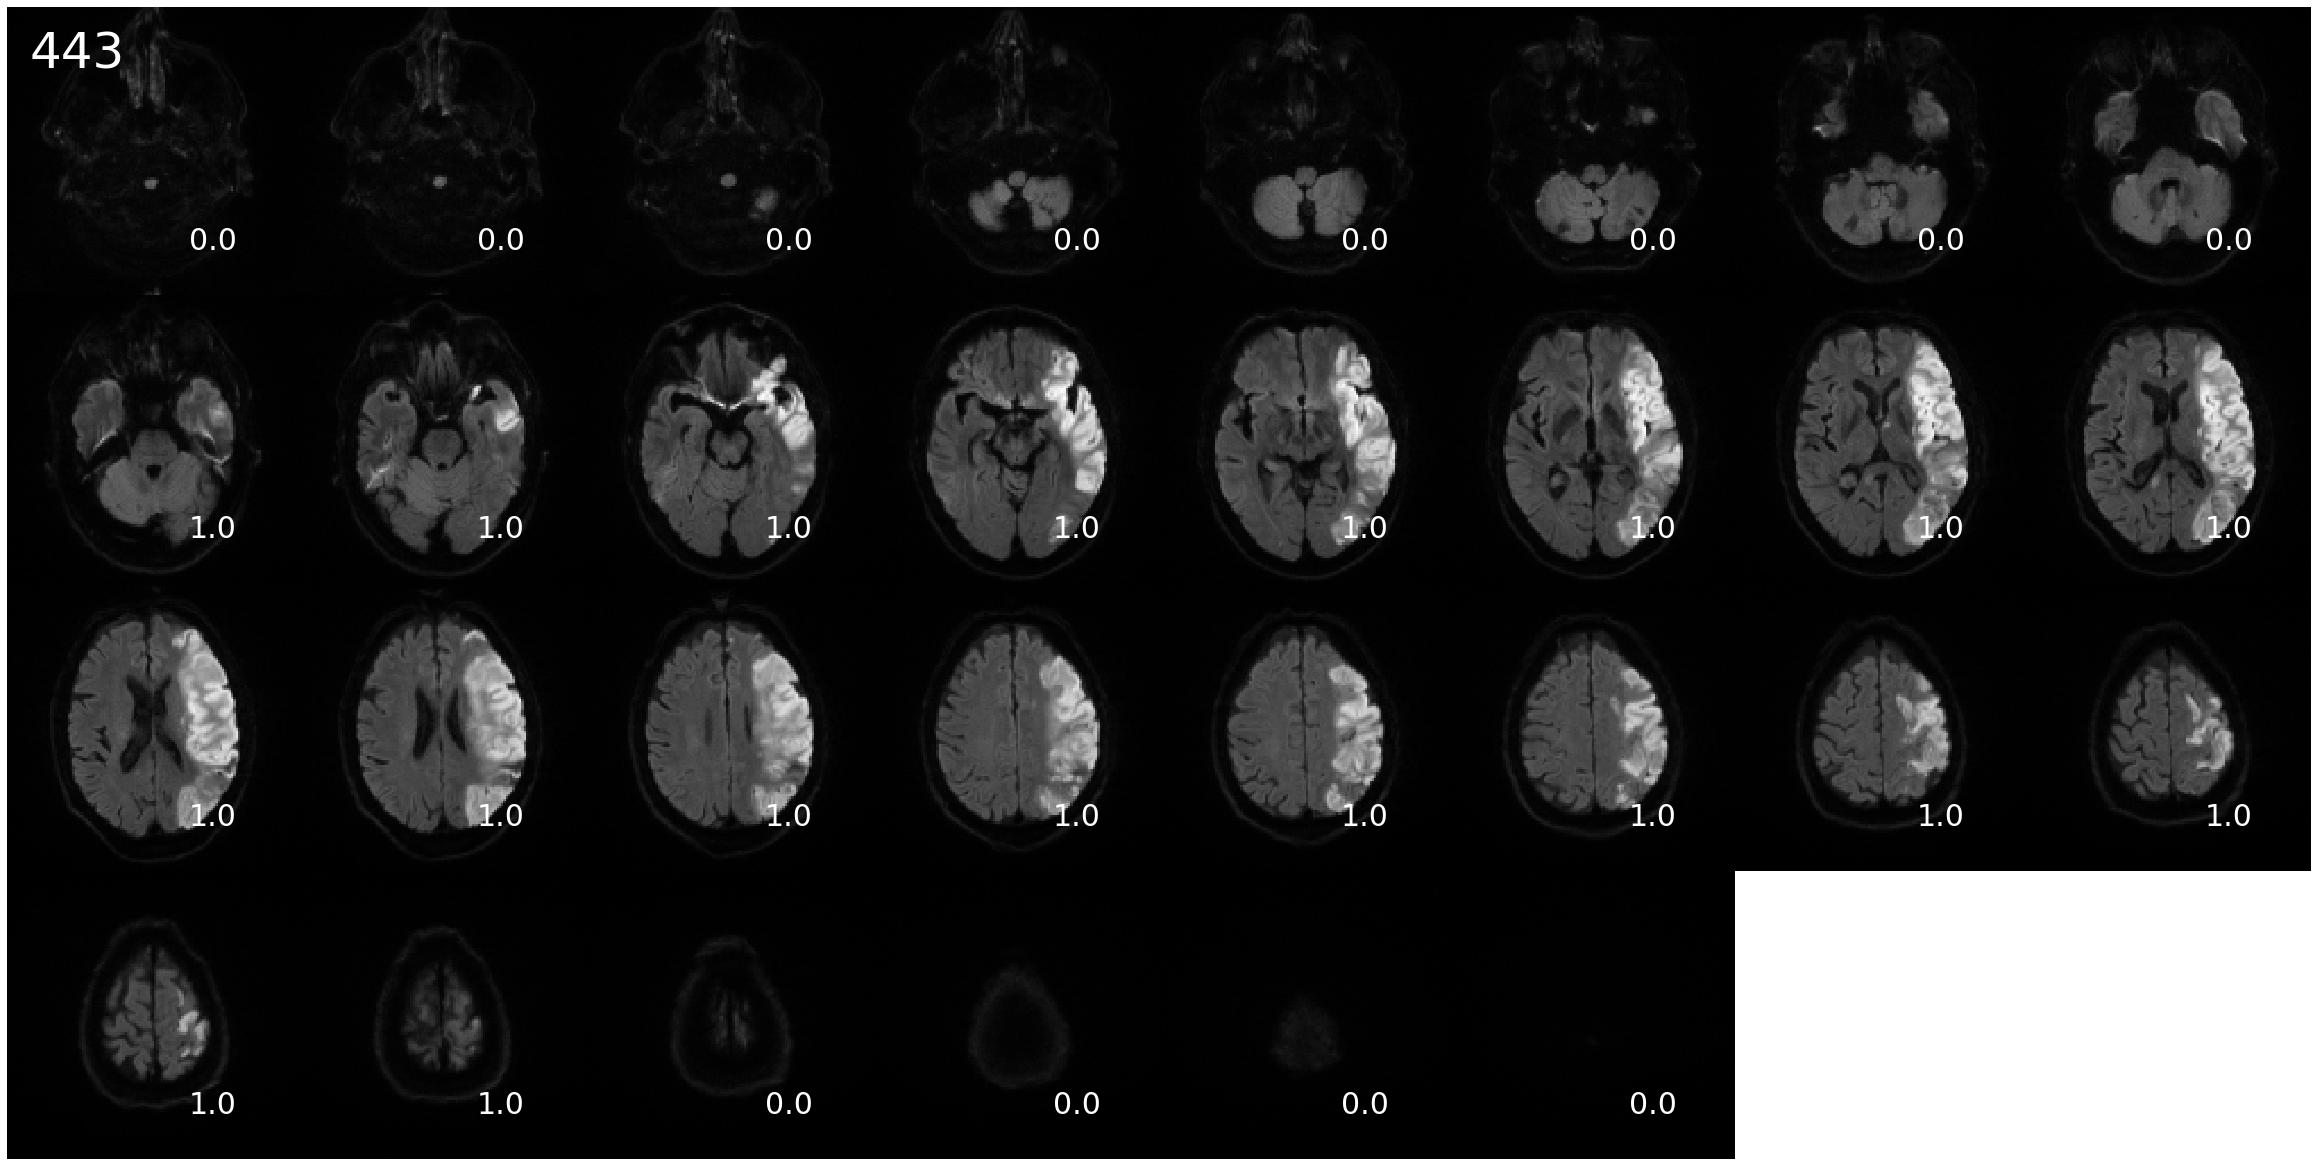

In [17]:
p = '443'
mri, labels = load_from_h5(p)
plot_3d_slices(mri, labels, p, 'axial', vmax = 1)

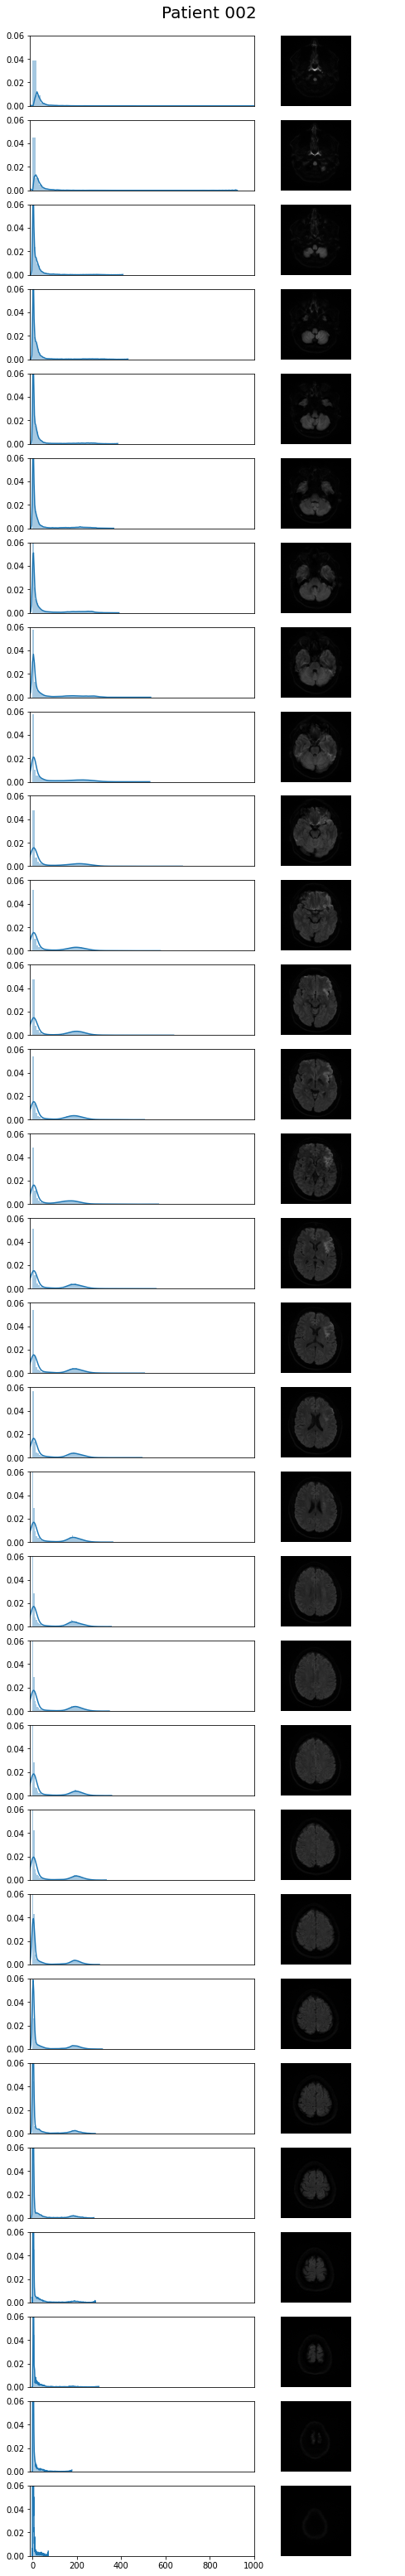

In [18]:
plot_spectrum(p)